# Stress binary classification with Logistic Regression


## Contents
* [Introduction](#Introduction)
    * [Import libraries](#Import-libraries)
* [Feature corellation dataframe](#Feature-corellation-dataframe)
* [Apply logistic regression with no feature optimisation](#Apply-logistic-regression-with-no-feature-optimisation)
* [Feature optimisation](#Feature-optimisation)
* [Logistic Regression with feature reduction](#Logistic-Regression-with-feature-reduction)

<br/><br/>


## Introduction
[[back to contents]](#Contents)

This notebook uses the LIWC extracted features from the Receptiviti API and trains a logistic regression model on the dreaddit dataset to calssify the "stress"/ "no stressed" posts. <br>
It explolers the effect of feature reduction with the method of pearson's correlation coefficient association to the target variable "stress" and the effect of this feature reduction on the F1 score. The data used consists of balanced instances between "stress"/ "no stress" classes. F1 score is used as the evaluation metric which will give us a better understanding on the False Positive and False Negative predictions. 





In [20]:
# Run this command to download en_core_web_md if required
!python -m spacy download en_core_web_sm

### Import libraries
[[back to contents]](#Contents)

In [2]:
import nltk
import pandas as pd 
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
import re
import json
import requests
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
import wordcloud
from scipy.stats import pearsonr
import string
import spacy
import pickle
import io
import os
import itertools
sp = spacy.load('en_core_web_sm')

%config Completer.use_jedi = False
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cncos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#set the relative paths
INTERIM_DATA_FOLDER = os.path.join("..", "..","..", "data", "interim")
RAW_DATA_FOLDER = os.path.join("..", "..", "..", "data", "raw")
INTERIM_DATA_FOLDER

'..\\..\\..\\data\\interim'

**Asumptions/Notes:** <p>
[1] The posts have been lemmatised and tokenise which means the setences have lost their punctuation. It is assumed that this approach does not have a great impact on the LIWC vocabulary metrics. <p>



Declaration of functions. 
<p> The _functions get_payload_and_url()_ and _call_receptiviti_api()_ to be called **only** when the api is called on new data. Use these two functions with caution as they use up the API allowance.

In [ ]:
get_payload_and_url()

In [22]:
#check type of content 
def get_payload_and_url(plot, API_URL):
    """
    Parameter
    ----------
    plot: can take in a text or list of texts
    API_URL: this must be the URL of the API.
    
    Return
    ----------
    Returns a dictionary of the content to be parsed on to the LIWC API.
    
    """
    
    if len(plot)<1:
        print("ERROR: 'text' should not be empty")
        return {}
    if isinstance(plot, str):
        return ({
                    "content": plot
                }, API_URL)
    if isinstance(plot, list):
        return ([{
                    "content": content
        } for content in plot], API_URL + '/bulk')

#call the LIWC vocabulary API to analyse the data
def call_receptiviti_api(plot, API_URL, API_key, API_secret):
    
    """
    Parameter
    ----------
    plot: can take in a text or list of texts
    API_URL: this must be the URL of the API.
    API_key: this must be the API key received upon registration.
    API_secret: this must be the API secret received upon registration.
    
    
    Return
    ----------
    Returns a json file with the analysis from the LIWC dictionary.
    
    """
    
    payload, url = get_payload_and_url(plot, API_URL)
    results = []
    if len(payload)>0:
        response = requests.post(url, data=json.dumps(payload), auth=(API_key, API_secret), headers = {'Content-Type': 'application/json'})
        if response.status_code==200:
            results = response.json()
    return results


# filter, tokenize and lemmatize each post
def lemmatize_text(posts_corpus):
    """
    Parameter
    ----------
    posts_corpus: this must be a pd.DataFrame of the posts

    Return
    ----------
    Returns a list of all posts lemmatized and filtered to inlcude only words.
    
    """
    lemmatizer = WordNetLemmatizer()
    text=[]
    for post, label in zip(posts_corpus.post, posts_corpus.label):
        tokens = [word.lower() for word in nltk.word_tokenize(post)]
        word_tokens = []
        for token in tokens:
            # include only words
            if re.search('^[a-zA-Z]+$', token):
                word_tokens.append(lemmatizer.lemmatize(token))
        text.append(" ".join(word_tokens))
    return text

#return all LIWC metrics
def LIWC_metrics_all(response):
    return response['results'][0]['dictionary_measures']

#return all Reciptiviti metrics
def Rec_metrics_all(response):
    return response['results'][0]['receptiviti_measures']


#return the n top LIWC metrics
def LIWC_metrics_n(response, n=20):
    """
    Select n number of top metrics, sorted highest to lowest  
    """
    #sort the LIWC metrics by higher to lower scores
    LIWC_metrics_all= LIWC_metrics(response)
    LIW_metrics_sorted = dict(sorted(LIWC_metrics_all.items(), key=lambda item: item[1], reverse=True))
    return dict(list(LIW_metrics_sorted.items())[:n])

#return the n top Receptiviti metrics
def Rec_metrics_n(response, n=20):
    """
    Select n number of top metrics, sorted highest to lowest  
    """
    #sort the receptiviti metrics by higher to lower scores
    Rec_metrics_all= Rec_metrics(response)
    Rec_metrics_sorted = dict(sorted(Rec_metrics_all.items(), key=lambda item: item[1], reverse=True))
    return dict(list(Rec_metrics_sorted.items())[:n])

#funtion to create the LIWC_vocabulary analysis dataframe
def LIWC_analysis_df(features, posts_sample, LIWC_analysis):
    Analysis_scores=np.empty( (len(posts_sample),len(features)) ) 
    for i, entry in enumerate(LIWC_analysis['results']):
        Analysis_scores[i] = list(entry['dictionary_measures'].values()) + list(entry['receptiviti_measures'].values())
    scores = pd.DataFrame(data=Analysis_scores, columns=features) 
    return( pd.concat( [posts_sample, scores], axis=1 ) )



In [5]:
# declare the paths to data
data_path = os.path.join( RAW_DATA_FOLDER, "dreaddit_dataset", "dreaddit_train.csv")

processed_vocab = os.path.join(INTERIM_DATA_FOLDER, "LIWC_feature_extraction_dreaddit_data.csv")

#load the features 
features_path = os.path.join(INTERIM_DATA_FOLDER, "features.csv")
features = pd.read_csv(features_path, header=None).squeeze()
stopwords = nltk.corpus.stopwords.words('english')

#load the raw data
df = pd.read_csv(data_path)
posts= df[['text','label']]
posts.columns = ['post', 'label']


In [6]:
LIWC_vocabulary_analysis = pd.read_csv(processed_vocab)

In [7]:
LIWC_vocabulary_analysis.head(3)

,id,post,label,LIWC_achievement,LIWC_adjectives,LIWC_admiration,LIWC_adverbs,LIWC_affective_processes,LIWC_affiliation,LIWC_all_punctuation,...,Rec_power,Rec_reward,Rec_risk_aversion,Rec_risk_seeking,Rec_self_assured,Rec_self_conscious,Rec_sociable,Rec_social,Rec_stress_prone,Rec_trusting
0,33181,he said he had not felt that way before sugget...,1,0.017699,0.061947,0.0,0.053097,0.088496,0.000000,0,...,97.406193,10.874329,94.293636,55.673260,28.705225,78.002095,32.398547,1.828304,49.194162,15.770581
1,2606,hey there not sure if this is the right place ...,0,0.038462,0.019231,0.0,0.038462,0.048077,0.057692,0,...,99.974813,97.719294,3.355955,51.121410,53.005651,50.793528,51.172628,87.956237,49.078470,51.151149
2,38816,my mom then hit me with the newspaper and it s...,1,0.006135,0.012270,0.0,0.018405,0.024540,0.055215,0,...,9.970624,93.329913,5.507738,48.969627,59.695824,44.101386,76.174750,99.027264,72.981777,61.252182


## Feature corellation dataframe
[[back to contents]](#Contents)

The number of features (163) is too large to plot the heatmap and get a good understanding of corellations.
Thherefore we run the corellation of all features against the main target 'label' and we select those only _>perc_; where perc is the user defined threshold.

In [8]:
# note that pandas corellattion calculates the corellation for all numerical features only
# categorical features are excluded 
cor = LIWC_vocabulary_analysis.corr()
#find the features which have 0/nan values  
features_to_drop = cor.columns[cor.isnull().all()]
#drop the nan features from all rows
cor.drop(labels=features_to_drop, axis=0,inplace=True)
#drop the nan features from all columns
cor.drop(labels=features_to_drop, axis=1,inplace=True)
#store the target variable 
target = LIWC_vocabulary_analysis.label



Functions declaration

In [9]:
#create dataframe to hold the highly corellated features
def hcf_(cor_df, data, perc):
    """
    This function returns the dataframe of features with correlation degree in relation to
    the target variable 'label' higher than the 'perc' variable.
    """
#retrieve the corellated features with correlation > perc .Applying absolute values
    correlated_features_sorted = abs(cor_df.label).sort_values(ascending=True)
    highly_corellated_features = correlated_features_sorted[correlated_features_sorted > perc].index
    score_df = data[highly_corellated_features].reset_index(drop=True)
    return pd.concat([data.id, data.label, score_df], axis=1)    


#Return the optmised selection of features. 
#Features highly correlated between them are filtered, and only the highest
#correlated feature wih target 'label' is kept.

def optimised_features(hcf, thr = 0.8):
    #find the pairs of features with degree of correlation > threshold 
    features_selected = hcf.iloc[:,2:]
    features_selected_corr = features_selected.corr()
    pairs=[]
    counter=1
    for row in range(len(features_selected_corr)):
        for column in range(counter, len(features_selected_corr)): 
            if (abs(features_selected_corr.iloc[row,column]) > thr) and (features_selected_corr.iloc[row,column] < 1) :
                pairs.append((features_selected_corr.index[row], 
                             features_selected_corr.columns[column],features_selected_corr.iloc[row,column]  ))
        counter+=1


    #filter the features which are higher correlated to the target 'label'
    features_to_disregard = []
    for pair in pairs:
        if abs(pearsonr(hcf[pair[0]], hcf.label)[0])  >= abs(pearsonr(hcf[pair[1]], hcf.label)[0]):
            features_to_disregard.append(pair[1])
        else:
            features_to_disregard.append(pair[0])
    ff = list(set(features_to_disregard))
    #final list of features to use 
    return [feat_ for feat_ in hcf.columns if feat_ not in ff ][2:]
    

#apply logistic regression and return the f1 score    
def log_reg_f1(feat_list, hcf, scaler, mdl, f1_score, testz=0.2):
    """
    The feat_list is the output of the optimised_features function. If no
    feature optimisation is applied then feat_list = hcf.columns (only features).
    """
    
    X = hcf[feat_list]
    y = hcf['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testz, random_state=42)
    log_r_pipe = make_pipeline(scaler, mdl)
    log_r_pipe.fit(X_train, y_train)
    predictions = log_r_pipe.predict(X_test)
#     print('\t\tClassification report\n\n', classification_report(y_test, predictions,digits=3))
    return f1_score(y_test, predictions).round(3)

## Apply logistic regression with no feature optimisation
[[back to contents]](#Contents)

Run the logistic regression on all features with variable pearson's correlation coefficient as a threshold for feature selection.

In [11]:
# run the logistic regression with all features, perc = 0
hcf = hcf_(cor, LIWC_vocabulary_analysis, perc= 0).iloc[:,:-1]
X = hcf.iloc[:,2:]
y = hcf['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

log_r_pipe = make_pipeline(StandardScaler(), LogisticRegression(max_iter=250))
log_r_pipe.fit(X_train, y_train)
predictions = log_r_pipe.predict(X_test)
print("Confusion Matrix\n" + '='*15 +'\n', confusion_matrix(y_test, predictions), "\n" + '='*15 + '\n' )
print('\t\tClassification report\n\n', classification_report(y_test, predictions,digits=3))

Confusion Matrix
 [[198  83]
 [ 64 211]] 

		Classification report

               precision    recall  f1-score   support

           0      0.756     0.705     0.729       281
           1      0.718     0.767     0.742       275

    accuracy                          0.736       556
   macro avg      0.737     0.736     0.735       556
weighted avg      0.737     0.736     0.735       556



In [12]:
#run the logistic regression with varied pearson's correlation coefficient 'perc'
scaler = StandardScaler()
mdl = LogisticRegression(max_iter=250)
perc = np.arange(0,0.5,0.05)
f1_s = []
for perc_i in perc:
    hcf = hcf_(cor, LIWC_vocabulary_analysis, perc = perc_i).iloc[:,:-1]
    f1score = log_reg_f1(hcf.columns[2:], hcf, scaler, mdl, f1_score, testz= 0.2)
    f1_s.append(f1score)
    print("pearsons_correlation % thrshd: {0}\t\t f1_Score: {1}"
          .format(perc_i.round(2), f1score ))

pearsons_correlation % thrshd: 0.0		 f1_Score: 0.742
pearsons_correlation % thrshd: 0.05		 f1_Score: 0.744
pearsons_correlation % thrshd: 0.1		 f1_Score: 0.738
pearsons_correlation % thrshd: 0.15		 f1_Score: 0.743
pearsons_correlation % thrshd: 0.2		 f1_Score: 0.75
pearsons_correlation % thrshd: 0.25		 f1_Score: 0.736
pearsons_correlation % thrshd: 0.3		 f1_Score: 0.743
pearsons_correlation % thrshd: 0.35		 f1_Score: 0.74
pearsons_correlation % thrshd: 0.4		 f1_Score: 0.724
pearsons_correlation % thrshd: 0.45		 f1_Score: 0.72


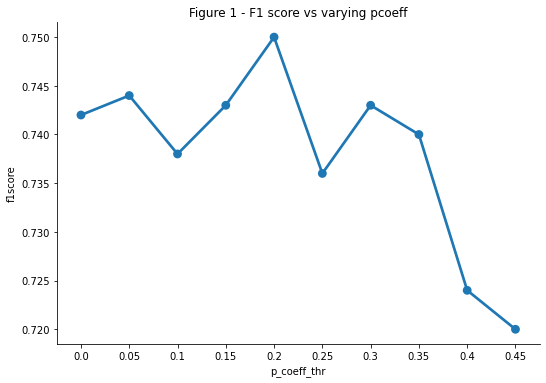

In [13]:
# plot the scores

scores_df = pd.DataFrame(data = [perc.round(2), f1_s], index = ['p_coeff_thr', 'f1score']).T
sns.catplot(x = 'p_coeff_thr', y = 'f1score', data = scores_df, kind='point', aspect=1.5)
plt.title('Figure 1 - F1 score vs varying pcoeff')
plt.show()

## Feature optimisation
[[back to contents]](#Contents)

From the selected features we apply further correlation calculation among them. Features with high degree of correlation will indicate that significant information is duplicated between them therefore we need to drop the ones with the lower correlation to the target value. <p>
This will help to maintain high level of accuracy with far fewer features. <p>
Remind that the selected features are chosen by selecting the _perc_ variable in the _hcf_()_ function above.

In [14]:
hcf = hcf_(cor, LIWC_vocabulary_analysis, perc= 0.2).iloc[:,:-1]

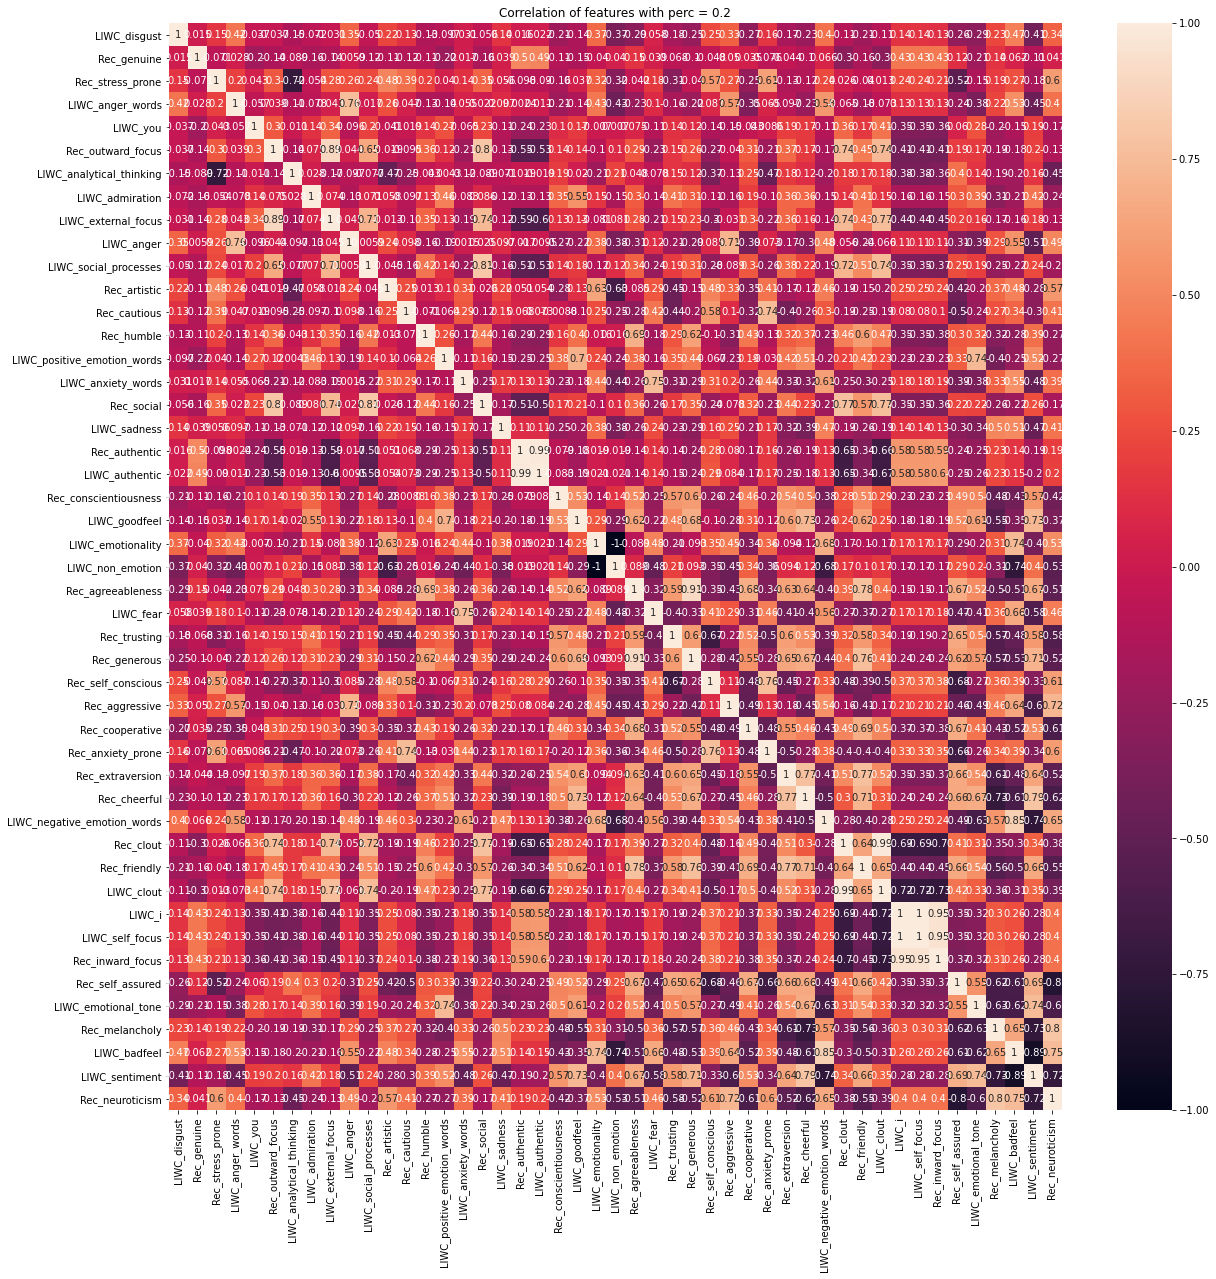

In [15]:
features_selected = hcf.iloc[:,2:]
#we will print the correlationj heatmap to visualise the most correlated features

plt.figure(figsize = (20,20))
heatmap = sns.heatmap(features_selected.corr(), vmin=-1, vmax=1, annot=True)
plt.title("Correlation of features with perc = 0.2")
plt.show()

With perc = 0.2 we have 47 features. We see that there is a huge number of these which are highly correlated |corr|>0.8 degree of correlation. Lets find these pairs.

## Logistic Regression with feature reduction
[[back to contents]](#Contents)

In [16]:
scaler = StandardScaler()
mdl = LogisticRegression(max_iter=250)
perc = np.arange(0.1,0.5,0.05).round(2)
no_of_features = []
f1_s =[]
for perc_i in perc:
    hcf = hcf_(cor, LIWC_vocabulary_analysis, perc = perc_i).iloc[:,:-1]
    fl = optimised_features(hcf, 0.8)
    no_of_features.append(len(fl))
    f1score = log_reg_f1(fl, hcf, scaler, mdl, f1_score, testz= 0.2)
    f1_s.append(f1score)
    print("pearsons_correlation % thrshd: {0}\t number of features: {1}\t f1_Score: {2}"
          .format(perc_i, len(fl), f1score ))



pearsons_correlation % thrshd: 0.1	 number of features: 66	 f1_Score: 0.76
pearsons_correlation % thrshd: 0.15	 number of features: 51	 f1_Score: 0.75
pearsons_correlation % thrshd: 0.2	 number of features: 35	 f1_Score: 0.746
pearsons_correlation % thrshd: 0.25	 number of features: 23	 f1_Score: 0.736
pearsons_correlation % thrshd: 0.3	 number of features: 14	 f1_Score: 0.737
pearsons_correlation % thrshd: 0.35	 number of features: 9	 f1_Score: 0.739
pearsons_correlation % thrshd: 0.4	 number of features: 3	 f1_Score: 0.716
pearsons_correlation % thrshd: 0.45	 number of features: 2	 f1_Score: 0.72


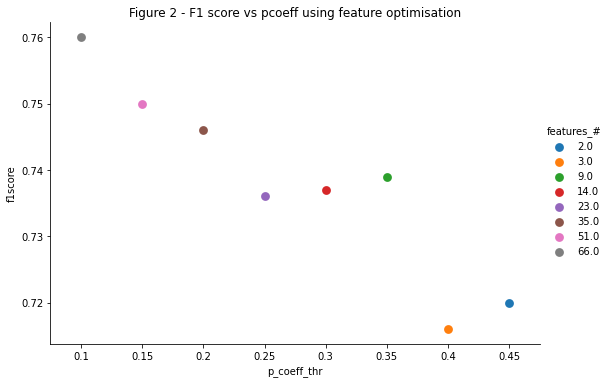

In [17]:
#plot the scores 
scores_df = pd.DataFrame(data = [perc, no_of_features, f1_s], index = ['p_coeff_thr', 'features_#', 'f1score']).T
fig1 = sns.catplot(x = 'p_coeff_thr', y = 'f1score', hue = 'features_#', 
            data = scores_df, kind='point', aspect=1.5)
plt.title('Figure 2 - F1 score vs pcoeff using feature optimisation')
plt.show()

By selecting the threhold for the pearson's correlation coefficient at perc = 0.1 we get the highest f1 score which is $\approx$0.76 which is quite good.
<p> Now let's see which are these 66no. which deduce from the feature optimisation function and we can use to train and predict future models with logistic regression.

In [18]:
hcf = hcf_(cor, LIWC_vocabulary_analysis, perc = 0.1).iloc[:,:-1]
fl = optimised_features(hcf, 0.8)
f1score = log_reg_f1(fl, hcf, scaler, mdl, f1_score, testz= 0.2)
print(fl)

['LIWC_personal_concerns', 'Rec_emotionally_aware', 'LIWC_causation', 'Rec_intellectual', 'LIWC_leisure', 'Rec_active', 'Rec_risk_seeking', 'LIWC_female', 'LIWC_focus_present', 'LIWC_six_plus_words', 'LIWC_we', 'LIWC_affective_processes', 'LIWC_conjunctions', 'LIWC_gratitude', 'Rec_impulsive', 'Rec_sociable', 'LIWC_dictionary_words', 'LIWC_love', 'LIWC_swear_words', 'Rec_energetic', 'Rec_dutiful', 'LIWC_adverbs', 'Rec_ambitious', 'LIWC_risk', 'LIWC_affiliation', 'LIWC_personal_pronouns', 'LIWC_articles', 'Rec_risk_aversion', 'LIWC_function_words', 'LIWC_sad_words', 'LIWC_feel', 'LIWC_disgust', 'Rec_genuine', 'Rec_stress_prone', 'LIWC_anger_words', 'LIWC_you', 'LIWC_analytical_thinking', 'LIWC_admiration', 'LIWC_external_focus', 'LIWC_anger', 'Rec_artistic', 'Rec_cautious', 'Rec_humble', 'LIWC_positive_emotion_words', 'LIWC_anxiety_words', 'Rec_social', 'LIWC_sadness', 'LIWC_authentic', 'Rec_conscientiousness', 'LIWC_goodfeel', 'LIWC_emotionality', 'LIWC_fear', 'Rec_trusting', 'Rec_gene

<br>

Comparing the results from figure 1 to those in figure 2 we see that the f1 score is increased at pcoeff = 0.1 when applying feature optimisation.

<br><br><br><br>